##
Machine Learning Ödevi


Uygulama için bazı paketleri içe aktarmamız gerekiyor.

In [1]:
import os
import pathlib
import cv2
import time
import re
from glob import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from PIL import Image

print("Tensorflow: v{}".format(tf.__version__))
%matplotlib inline

Tensorflow: v2.8.2


In [ ]:
!pwd
os.getcwd()
!pwd
os.chdir('/tmp')
!pwd
"/content/dataset/train"

/tmp
/tmp
/tmp


### Veri Kümesini Hazırlama
Daha önce bahsedilen veri kümesi ImageNet'tir.582 Köpek 598 ördek resmi vardır.

 - Random Crop: Orijinal görüntüden, yalnızca rastgele boyut sınırlama kutusunu seçip kırpıyoruz.
 - Random Rotation: Orijinal görüntüyü rastgele açıyla döndürebiliriz.
 - flip_left_right: Soldan sağa dönen aynalarla dönüşümü hayal edebiliriz.
 

In [2]:
data_dir = pathlib.Path(r"/content/dataset/")
file_name = os.listdir(data_dir)
print(file_name)
img_height,img_width=180,180
batch_size=32

['ordek', '.ipynb_checkpoints', 'kopek']


In [ ]:
##Creating Training Dataset##

In [4]:
# tf.keras.preprocessing.image_dataset_from_directory --> Generates a tf.data.Dataset from image files in a directory.
train= tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
# image_dataset_from_directory --> takes directory of the images, validation spilit ratio(%80 training, %20 validation), subset --> One of "training" or "validation". Only used if validation_split is set. first subset is gonna be a training,
# label_mode='categorical' means that different classes/categories
# of classes, dataset may contain images with different dimensions so we need to resize all of them to same size and image_size is for doing that, batch_size kacar kacar vericez datayı

Found 1200 files belonging to 3 classes.
Using 960 files for training.


In [ ]:
##Creating Validation Dataset##

In [5]:
val = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1200 files belonging to 3 classes.
Using 240 files for validation.


In [6]:
class_names = train.class_names
print(class_names)


['.ipynb_checkpoints', 'kopek', 'ordek']


In [ ]:
## Visualizing the data ##

Verilerin yüklenip yüklenmediğini test edelim

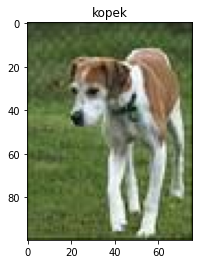

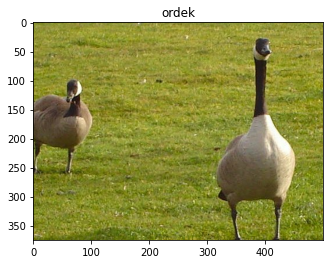

In [7]:
kopek, label = load('/content/dataset/kopek/kopek11.jpg', 'kopek')

fig, ax = plt.subplots()
ax.imshow(kopek/255.)
ax.set_title(label)
plt.show()


ordek, label = load('/content/dataset/ordek/ordek11.jpg', 'ordek')

fig, ax = plt.subplots()
ax.imshow(ordek /255.)
ax.set_title(label)
plt.show()

Input tipini düzeltmek için gereklidir. Bunun için yeniden boyutlandırma işlevini uygulamamız gerekiyor. Tensorflow, görüntü işlemeyi önceden işlemek için görüntü sınıfına --tf.image-- sahiptir. onu kullanabiliriz. Boyut bağımsız değişkenini --yükseklik, genişlik-- sırasına sahip olması gerekir.

In [8]:
def resize(input_image, size):
    return tf.image.resize(input_image, size)

In [ ]:
## Random Crop işlemi##

In [9]:
def random_crop(input_image):
    return tf.image.random_crop(input_image, size=[150, 150, 3])

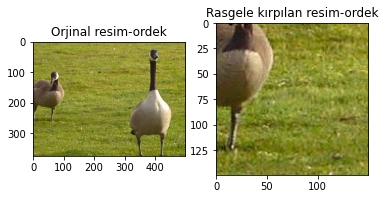

In [16]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(ordek / 255.)
ax[0].set_title("Orjinal resim")

ax[1].imshow(random_crop(ordek) / 255.)
ax[1].set_title("Rasgele kırpılan resim-ordek")
plt.show()


And think about that when validation or test data is used. Can Random_crop help the performance of model? You know that validation and test processs don't affect the model training, it just measure the accuracy. So we don't need to data augmentation process in validation and test data. And sometimes random crop may crop the useless section of image that cannot classify correctly. In that case, central_crop function is required, not random crop. So We implement it using tensorflow.

From [documentation](https://www.tensorflow.org/api_docs/python/tf/image/central_crop), it needs to define `central_fraction` as an argument. It means that this API crops from the center point based on the fraction. Our purpose is to made an input data with 150x150x3.
But remember that the size of each image may be different. So we need to resize it in advance.

In [11]:
def central_crop(input_image):
    image = resize(input_image, [176, 176])
    return tf.image.central_crop(image, central_fraction=0.84)

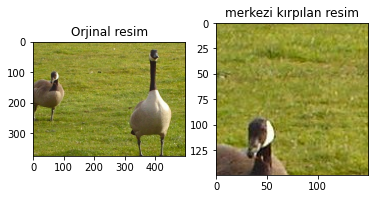

In [17]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(ordek / 255.)
ax[0].set_title("Orjinal resim")

ax[1].imshow(random_crop(ordek) / 255.)
ax[1].set_title("merkezi kırpılan resim")
plt.show()

Then we can implement random_rotation API.

In [18]:
def random_rotation(input_image):
    res = np.random.randint(0, 3, 1)
    return tf.image.rot90(input_image, k=res[0])

def random_jitter(girdi_resmi):
    # Resize it to 176 x 176 x 3
    resim = resize(girdi_resmi, [176, 176])
    # Randomly Crop to 150 x 150 x 3
    resim = random_crop(resim)
    # Randomly rotation
    resim = random_rotation(resim)
    # Randomly mirroring
    resim = tf.image.random_flip_left_right(resim)
    return resim

Once we define several helper functions for data augmentation, we can merge it in one API, called `random_jitter`. And we can add another image transformation function, like `random_flip_left_right`

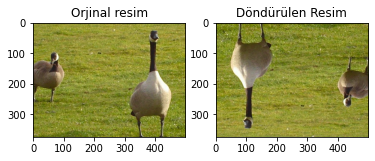

In [22]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(ordek / 255.)
ax[0].set_title("Orjinal resim")

ax[1].imshow(random_rotation(ordek) / 255.)
ax[1].set_title("Döndürülen Resim")
plt.show()

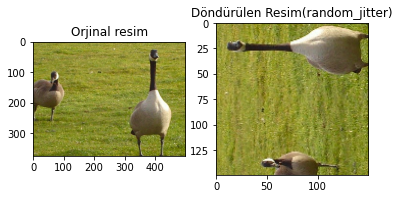

In [24]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(ordek / 255.)
ax[0].set_title("Orjinal resim")

ax[1].imshow(random_jitter(ordek) / 255.)
ax[1].set_title("Döndürülen Resim(random_jitter)")
plt.show()

One more API we need to implement is `normalize`. Normalization is one of method for rescaling. There are several techniques for normalization. But in this API, our normalize function will be

- convert the value range from [0, 255] to [0, 2]
- move the value range from [0, 2] to [-1, 1]

After that, whole value in image will be in range of [-1, 1]

In [25]:
# görüntülerin normalleştirilmesi [-1, 1]
def normalize(giris_resmi):
    norm = (tf.reduce_max(giris_resmi) + tf.reduce_min(giris_resmi)) / 2
    giris_resmi = giris_resmi / norm - 1
    return giris_resmi

Normalize bitti. Eğitim verilerini ve doğrulama verilerini tek bir yerde yapmak faydalı olacaktır.


In [26]:
def load_image_train(image_file, label):
    image, label = load(image_file, label)
    image = random_jitter(image)
    image = normalize(image)
    return image, label

def load_image_val(image_file, label):
    image, label = load(image_file, label)
    image = central_crop(image)
    image = normalize(image)
    return image, label

In [ ]:
##data augmentation'ın işlevselliğini kontrol edelim

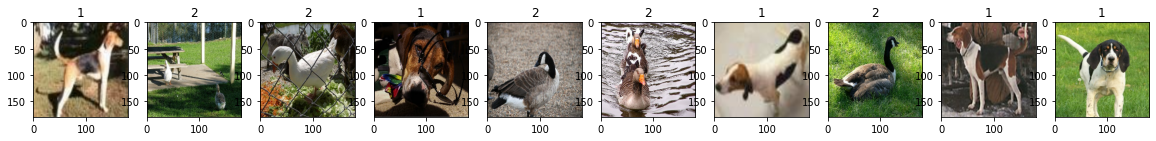

In [42]:
for images, labels in train.take(1):
    fig, ax = plt.subplots(1, 10, figsize=(20, 6))
    for j in range(10):
        image = images[j].numpy()
        image = image / np.amax(image)
        image = np.clip(image, 0, 1)
        ax[j].imshow(image)
        ax[j].set_title(labels[j].numpy())
plt.show()

In [ ]:
##Modelin Oluşturulması##

In [48]:
resnet_model = tf.keras.Sequential() # Ağı başlatma (sıralı, daha sonra reklam vereceğimiz katmanların bir sırayla - birbiri ardına - eklenmesini sağlar -) tf.keras.models.Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model) # üstte oluşturduğumuz resnet_modelimize bu önceden eğitilmiş modeli ekledik

#!! include_top=False, kendi girdi katmanımızı ve kendi çıktı katmanımızı (input_shape) kullanacağımız anlamına gelir (bunu neden yapıyoruz --> çünkü orijinal resnet modeli farklı görüntü boyutlarında vb. eğitilmiş olabilir) 
# sonra görüntü boyutunu, kullanacağımız havuz türünü (pooling) (ortalama veya maksimum), sınıf sayısını ve hangi ağırlığı kullanacağımızı belirliyoruz #!! Layer.trainable=False, resnet50 modelinin ağırlıklarını değiştirmediğimiz anlamına gelir ("ağırlıkları tekrar öğrenmeyin, bu ağırlıkları olduğu gibi tutun" modellemek için diyoruz) sadece girdi katmanımızı ve çıktı katmanımızı ekleyeceğiz ve sonra
# öğrenme süreci yapılacak (bu çok zaman kazandırır)


In [49]:
##Modele tam bağlı giriş ve çıkış katmanı ekleme

In [50]:
resnet_model.add(tf.keras.layers.Flatten()) # reducing the dimensions
resnet_model.add(tf.keras.layers.Dense(512, activation='relu')) #!! These 512 neurons we added will be learning the new weight all the weight in the hidden layers will stay the same
resnet_model.add(tf.keras.layers.Dense(5, activation='softmax')) #!! These 5 neurons we added will be learning the new weight all the weight in the hidden layers will stay the same

In [51]:
##Model Summary

In [52]:
resnet_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 24,639,365
Trainable params: 1,051,653
Non-trainable params: 23,587,712
_________________________________________________________________


In [53]:
#Modeli derleyelim#

In [54]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])



In [55]:
history = resnet_model.fit(train, epochs=10, validation_data=val)
history = resnet_model.fit(train, epochs=10, validation_data=val)
resnet_model.save("/content/transfer_learning.h5")

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 129s 4s/step - loss: 0.2562 - accuracy: 0.9302 - val_loss: 0.0144 - val_accuracy: 0.9958
Epoch 2/10
30/30 [==============================] - 124s 4s/step - loss: 0.0482 - accuracy: 0.9875 - val_loss: 0.0924 - val_accuracy: 0.9750
Epoch 3/10
30/30 [==============================] - 138s 5s/step - loss: 0.0098 - accuracy: 0.9969 - val_loss: 0.0448 - val_accuracy: 0.9833
Epoch 4/10
30/30 [==============================] - 124s 4s/step - loss: 0.0232 - accuracy: 0.9896 - val_loss: 0.0481 - val_accuracy: 0.9750
Epoch 5/10
30/30 [==============================] - 132s 4s/step - loss: 0.0243 - accuracy: 0.9948 - val_loss: 0.0457 - val_accuracy: 0.9792
Epoch 6/10
30/30 [==============================] - 124s 4s/step - loss: 0.0120 - accuracy: 0.9958 - val_loss: 0.0629 - val_accuracy: 0.9875
Epoch 7/10
30/30 [==============================] - 123s 4s/step - loss: 0.0019 - accuracy: 0.9990 - val_loss: 0.0955 - val_accuracy: 0.9750
Epoch 8/10
30/30 [======

In [ ]:
##Modeli Kullanarak Tahmin Yapma

In [57]:
# resmi okumak için opencv kullanalım
image=cv2.imread('/content/resim1.jpg')
image_resized= cv2.resize(image, (img_height,img_width)) #!!! DONT FORGET TO RESIZE IT TO THE SAME SIZE THAT THE MODEL IS TRAINED ON, The model operates on an array of samples, therefore the dimensions of a loaded image need to be expanded by 1
image=np.expand_dims(image_resized,axis=0) # expending the dimesion of the image to make it 4 dimension
print(image.shape)

(1, 180, 180, 3)


In [58]:
#Now to make predictions, we simply call the predict method:
pred=resnet_model.predict(image)
print(pred)

[[2.1291802e-23 1.6541117e-10 1.0000000e+00 1.9884831e-19 1.5765134e-22]]


In [60]:
# Making model output more readable
output_class=class_names[np.argmax(pred)]
print("tahmin sonucu", output_class)

tahmin sonucu ordek
